# Data Analysis and Feature encoding

Before, moving on to the prediction step, the data needs to be analyzed first. This document presents the following stages of this case study.
1. Examining the data
2. Managiing the missing Values
3. Visualizing individual Data Columns
4. Cleaning the data
4. Checking Correlations
5. Feature Encoding
6. Separating the known and unknown 'hits' data

Before moving on, let's import all the packages we'll be needing here.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from sklearn.feature_extraction import FeatureHasher

# Examining the Data

First, let's have a look at the data set as a whole to understand the schema of the data

In [2]:
nRowsRead = None  # This can be changed into an integer in order to load a smaller chunk of the data.
df = pd.read_csv('Case Study Data.csv', delimiter= ';', nrows = nRowsRead)
print(df.shape)
df.info()

(988681, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988681 entries, 0 to 988680
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   row_num            988681 non-null  int64 
 1   locale             988681 non-null  object
 2   day_of_week        988681 non-null  object
 3   hour_of_day        988681 non-null  int64 
 4   agent_id           988681 non-null  int64 
 5   entry_page         988681 non-null  int64 
 6   path_id_set        983792 non-null  object
 7   traffic_type       988681 non-null  int64 
 8   session_durantion  988681 non-null  object
 9   hits               988681 non-null  object
dtypes: int64(5), object(5)
memory usage: 75.4+ MB


There is a typo in one of the the column names, so let's correct this in order to avoid confusion later. Also, let's replace the unknown values with numpy nans for ease of  handlimg the unknown values.

In [3]:
# fixing the typo in the column name
df = df.rename(columns={'session_durantion': 'session_duration'})
# replacing missing values with Nan
df = df.replace('\\N', np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988681 entries, 0 to 988680
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   row_num           988681 non-null  int64 
 1   locale            988681 non-null  object
 2   day_of_week       988681 non-null  object
 3   hour_of_day       988681 non-null  int64 
 4   agent_id          988681 non-null  int64 
 5   entry_page        988681 non-null  int64 
 6   path_id_set       983792 non-null  object
 7   traffic_type      988681 non-null  int64 
 8   session_duration  988013 non-null  object
 9   hits              619235 non-null  object
dtypes: int64(5), object(5)
memory usage: 75.4+ MB


In [4]:
df.isnull().sum()

row_num                  0
locale                   0
day_of_week              0
hour_of_day              0
agent_id                 0
entry_page               0
path_id_set           4889
traffic_type             0
session_duration       668
hits                369446
dtype: int64

We can see here that the couple of feature columns also hae missing values. In the following section, let's tackle those those values.

# Fill in the missing values 

Let's start by filling in the missing values in session_duration by using a simple imputer with a mean strategy. We could have used an iterative imputer but that seemed to be an overkill for such a small number of missing values.

In [5]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer = imputer.fit(df[['session_duration']])
df['session_duration'] = imputer.transform(df[['session_duration']])
df['session_duration'] = df['session_duration'].astype(float) # changing to a numeric type after filling in the missing values 
df.isnull().sum()

row_num                  0
locale                   0
day_of_week              0
hour_of_day              0
agent_id                 0
entry_page               0
path_id_set           4889
traffic_type             0
session_duration         0
hits                369446
dtype: int64

Values filled in. Now, let's deal with the missing path_id_set values.

In [6]:
# analyzing the entries with missing path ids
df_no_path = df[df['path_id_set'].isna()]
print(df_no_path['session_duration'].describe())
print(df_no_path['hits'].describe())

count     4889.000000
mean       905.935570
std       6441.779028
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      82462.000000
Name: session_duration, dtype: float64
count     3153
unique      44
top          1
freq      2743
Name: hits, dtype: object


The session_duration and hits values where path_ids are zeros indicate that missing path_ids can be assumed as an 'empty set' of values rather than missing values. Also, changing the 'hits' column to numeric type after changing '\N' to np.nan earlier

In [7]:
df['hits'] = df['hits'].astype(float) # changing to numeric type; float because of numpy nans

# Visualizing individual columns

Here let's just visualize individual features of the data to get a better unserstanding of what we are dealing with

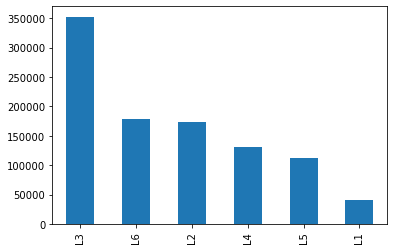

In [8]:
df['locale'].value_counts().plot(kind='bar')

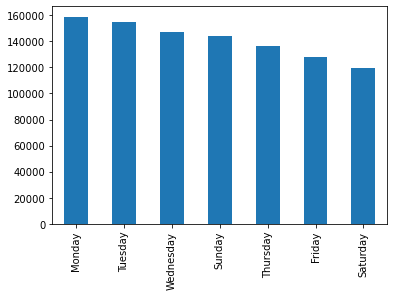

In [9]:
df['day_of_week'].value_counts().plot(kind='bar')

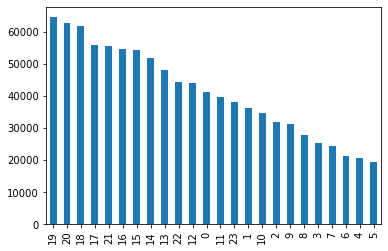

In [10]:
df['hour_of_day'].value_counts().plot(kind='bar')

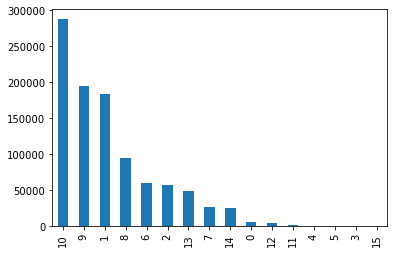

In [11]:
df['agent_id'].value_counts().plot(kind='bar')

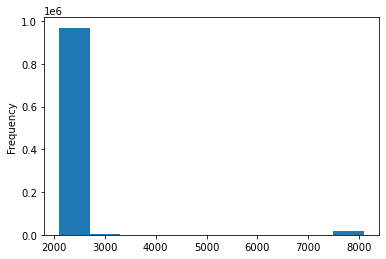

In [12]:
df['entry_page'].plot(kind='hist')

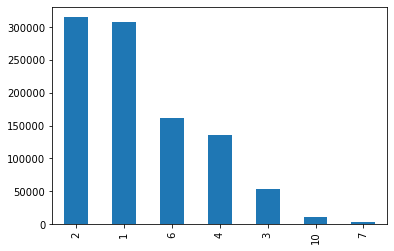

In [13]:
df['traffic_type'].value_counts().plot(kind='bar')

count    988681.000000
mean        492.918447
std        1920.873736
min           0.000000
25%           4.000000
50%          57.000000
75%         325.000000
max       86219.000000
Name: session_duration, dtype: float64


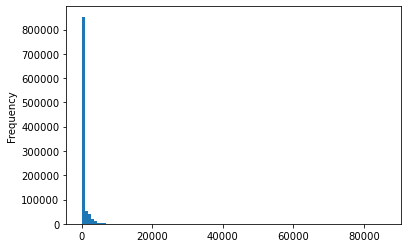

In [14]:
print(df['session_duration'].describe())
df['session_duration'].plot(kind='hist', bins=100)


The description of this column and its distribution tells us that there may be a very small fraction values that are skewing the picture and are not representative of the data in general. Let's deal with it in the next section.

In [15]:
df['path_id_set'].describe()

count     983792
unique    151267
top            0
freq       54444
Name: path_id_set, dtype: object

count    619235.000000
mean         18.210079
std          39.099699
min           1.000000
25%           3.000000
50%           7.000000
75%          19.000000
max        4174.000000
Name: hits, dtype: float64


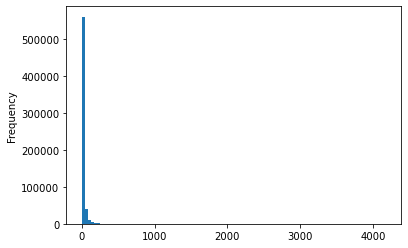

In [16]:
print(df['hits'].describe())
df['hits'].plot(kind='hist', bins=100)

Here again, we see a small number of outliers skewing the overall representation disproportionately.

# Data cleaning

Let's remove the extreme outliers. I'll be using quantiles to remove the extreme outliers. The model training improved drastically with this simple, yet effective, filtering on the two columns from the previous section.

In [17]:
def clean_by_quantile(df, columns, q_levels):
    for column, q_level in zip(columns, q_levels):
        if column in df.columns:
            q = df[column].quantile(q_level)
            df = df[df[column].isna() | (df[column] < q)]
    return df

In [18]:
df_clean = clean_by_quantile(df.copy(), ['session_duration', 'hits'], [0.99, 0.99])
df_clean.describe()

,row_num,hour_of_day,agent_id,entry_page,traffic_type,session_duration,hits
count,972595.000000,972595.000000,972595.000000,972595.000000,972595.000000,972595.000000,606811.000000
mean,494279.996615,13.223764,7.359923,2252.157428,2.793802,363.660166,14.961499
std,285416.255407,6.714663,3.861941,778.103739,1.925059,753.654021,20.458390
min,1.000000,0.000000,0.000000,2100.000000,1.000000,0.000000,1.000000
25%,247077.500000,8.000000,6.000000,2111.000000,1.000000,4.000000,3.000000
50%,494277.000000,14.000000,9.000000,2113.000000,2.000000,53.000000,6.000000
75%,741420.500000,19.000000,10.000000,2116.000000,4.000000,298.000000,18.000000
max,988680.000000,23.000000,15.000000,8101.000000,10.000000,5220.000000,149.000000


Furthermore, the correlation analysis - described later in this notebook - revealed that the number of hits have a higher correlation with the the number of locations in the path_id_set rather than the actual locations themselves. So we'll add an additional column to help us build a better model.

In [19]:
#mapping function to get the path_length from path_id_set
def get_path_length(x):
    if x is not np.nan:
        x = str(x)
        y = len(x.split(';'))
    else:
        y=0
    return y

In [20]:
df_clean['path_length'] = df_clean['path_id_set'].apply(lambda x: get_path_length(x))

Here, now we have a new column in our data.

# Correlations

Before checking correlations, we'll separate data with hits so that np.nans don't interfere with the correlation calculations

In [21]:
df_wo_hits = df_clean[df_clean['hits'].isna()]
df_hits = df_clean[df_clean['hits'].notna()]

First, let's observe the Correlation among continuous variables after path_length

In [22]:
cont_col = ['session_duration', 'path_length', 'hits']
df_cont = df_hits[cont_col] 
corr = df_cont.corr(method='spearman')
corr.style.background_gradient()

,session_duration,path_length,hits
session_duration,1.000000,0.499766,0.863663
path_length,0.499766,1.000000,0.559555
hits,0.863663,0.559555,1.000000


Then let's observe the  Correlation Ratio between hits and categorical features

In [23]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta


In [24]:
for cols in df_hits.columns:
    if cols not in ('session_duration', 'path_length', 'hits', 'row_num', 'path_id_set'):
        cor_ratio = correlation_ratio(df_hits[cols].tolist(), np.array(df_hits['hits'].tolist()))
        print ("Correlation ratio between " + cols + " & hits is = " + str(cor_ratio) + 
               ', whereas total # of categories is: ' + str(len(df_hits[cols].unique())))

Correlation ratio between locale & hits is = 0.06276009462852863, whereas total # of categories is: 6
Correlation ratio between day_of_week & hits is = 0.011333518612777115, whereas total # of categories is: 7
Correlation ratio between hour_of_day & hits is = 0.014458718061775722, whereas total # of categories is: 24
Correlation ratio between agent_id & hits is = 0.04480953822813183, whereas total # of categories is: 15
Correlation ratio between entry_page & hits is = 0.27392332994092466, whereas total # of categories is: 134
Correlation ratio between traffic_type & hits is = 0.30658855727576523, whereas total # of categories is: 7


In [ ]:
plot_col = ['day_of_week', 'locale', 'agent_id', 'entry_page', 'traffic_type', 'hour_of_day', 'hits']

df_plot = df_hits[plot_col]
sns.pairplot(df_plot)


This figure above shows us the pairwise plot of different features of our data. The next step after the understading of the data is to encode this data so that it can be fed into a machine learning model.

Before encoding, let's view how our cleaned DataFrame looks like now.

In [47]:
df_clean.describe()

,row_num,hour_of_day,agent_id,entry_page,traffic_type,session_duration,hits,path_length
count,972595.000000,972595.000000,972595.000000,972595.000000,972595.000000,972595.000000,606811.000000,972595.000000
mean,494279.996615,13.223764,7.359923,2252.157428,2.793802,363.660166,14.961499,2.041520
std,285416.255407,6.714663,3.861941,778.103739,1.925059,753.654021,20.458390,0.826147
min,1.000000,0.000000,0.000000,2100.000000,1.000000,0.000000,1.000000,0.000000
25%,247077.500000,8.000000,6.000000,2111.000000,1.000000,4.000000,3.000000,2.000000
50%,494277.000000,14.000000,9.000000,2113.000000,2.000000,53.000000,6.000000,2.000000
75%,741420.500000,19.000000,10.000000,2116.000000,4.000000,298.000000,18.000000,2.000000
max,988680.000000,23.000000,15.000000,8101.000000,10.000000,5220.000000,149.000000,74.000000


# Feature encoding

The feature encoding is a very immportant part for preparing the data for the model training and model prediction. So, getting the right kind of encoding for each feature is very important. This dataset is particularly challengng in that regard because it has features that are
1) nominal categorical
2) categorical with large number of categories
3) continous numerical
4) cyclical

First, let's start by converting all the nominal categorical variables to one hot encoding.

In [52]:
df_encoded = df_clean.copy().reset_index() # getting a new DataFrame instance for encodings

for i in ('locale', 'agent_id', 'traffic_type'):
    dummies = pd.get_dummies(df_encoded[i], drop_first=True,  prefix=i.split('_')[0])
    df_encoded = pd.concat([df_encoded, dummies], axis=1)
    df_encoded = df_encoded.drop(columns=[i]) 
df_encoded.describe()

,index,row_num,hour_of_day,entry_page,session_duration,hits,path_length,locale_L2,locale_L3,locale_L4,...,agent_12,agent_13,agent_14,agent_15,traffic_2,traffic_3,traffic_4,traffic_6,traffic_7,traffic_10
count,972595.000000,972595.000000,972595.000000,972595.000000,972595.000000,606811.000000,972595.000000,972595.000000,972595.000000,972595.000000,...,972595.000000,972595.000000,972595.000000,972595.000000,972595.000000,972595.000000,972595.000000,972595.000000,972595.000000,972595.000000
mean,494401.003385,494279.996615,13.223764,2252.157428,363.660166,14.961499,2.041520,0.174886,0.356318,0.132572,...,0.003790,0.048680,0.024993,0.000103,0.320642,0.054722,0.139639,0.166032,0.003070,0.010691
std,285416.255407,285416.255407,6.714663,778.103739,753.654021,20.458390,0.826147,0.379870,0.478911,0.339112,...,0.061445,0.215198,0.156104,0.010139,0.466724,0.227436,0.346612,0.372110,0.055324,0.102843
min,1.000000,1.000000,0.000000,2100.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,247260.500000,247077.500000,8.000000,2111.000000,4.000000,3.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,494404.000000,494277.000000,14.000000,2113.000000,53.000000,6.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,741603.500000,741420.500000,19.000000,2116.000000,298.000000,18.000000,2.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,988680.000000,988680.000000,23.000000,8101.000000,5220.000000,149.000000,74.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Next, we have two categorical features with a very large number of discrete categories. Using one-hot-encoding here will lead us to a bad place, named curse of dimensionality.
So, instead well limit the encodings for these features to 10 by using FeatureHasher for entry_page while we have already replaced path_id_set by path_length.

In [53]:
hasher = FeatureHasher(n_features=10, input_type='string')
hashed_features = hasher.fit_transform(df_encoded['entry_page'].astype(str))
hashed_features = hashed_features.toarray()
df_encoded = pd.concat([df_encoded.drop(columns=['entry_page']), pd.DataFrame(hashed_features, 
                                                                 columns=['ep_0', 'ep_1', 'ep_2', 'ep_3', 'ep_4', 
                                                                          'ep_5', 'ep_6', 'ep_7',
                                                                          'ep_8', 'ep_9'])], axis=1)



In [54]:
df_encoded.drop(columns=['path_id_set'], inplace=True)
df_encoded.describe()

,index,row_num,hour_of_day,session_duration,hits,path_length,locale_L2,locale_L3,locale_L4,locale_L5,...,ep_0,ep_1,ep_2,ep_3,ep_4,ep_5,ep_6,ep_7,ep_8,ep_9
count,972595.000000,972595.000000,972595.000000,972595.000000,606811.000000,972595.000000,972595.000000,972595.000000,972595.000000,972595.000000,...,972595.000000,972595.000000,972595.000000,972595.000000,972595.0,972595.0,972595.0,972595.000000,972595.000000,972595.000000
mean,494401.003385,494279.996615,13.223764,363.660166,14.961499,2.041520,0.174886,0.356318,0.132572,0.113310,...,0.585848,1.014003,-0.079324,-0.019134,0.0,0.0,0.0,-1.728529,0.065479,-0.507682
std,285416.255407,285416.255407,6.714663,753.654021,20.458390,0.826147,0.379870,0.478911,0.339112,0.316972,...,0.508024,0.273876,0.270358,0.139636,0.0,0.0,0.0,0.720100,0.252137,0.867897
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-2.000000,-2.000000,0.0,0.0,0.0,-3.000000,0.000000,-2.000000
25%,247260.500000,247077.500000,8.000000,4.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,-2.000000,0.000000,-2.000000
50%,494404.000000,494277.000000,14.000000,53.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,-2.000000,0.000000,0.000000
75%,741603.500000,741420.500000,19.000000,298.000000,18.000000,2.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,-1.000000,0.000000,0.000000
max,988680.000000,988680.000000,23.000000,5220.000000,149.000000,74.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,4.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,3.000000,0.000000


After adding hashed features, we're done with the categorical feature. 
Now we'll scale the contionuous features. various options were explored but the simplest option of MinMaxScaler worked as well as any other 

In [55]:
scaler  = StandardScaler()
# minmax = MinMaxScaler()
df_encoded[['path_length', 'session_duration']] = scaler.fit_transform(df_encoded[['path_length', 'session_duration']])
# df_encoded[['path_length', 'session_duration']] = minmax.fit_transform(df_encoded[['path_length', 'session_duration']])

df_encoded[['path_length', 'session_duration']].describe()


,path_length,session_duration
count,9.725950e+05,9.725950e+05
mean,1.709958e-16,-4.212431e-17
std,1.000001e+00,1.000001e+00
min,-2.471136e+00,-4.825296e-01
25%,-5.025726e-02,-4.772221e-01
50%,-5.025726e-02,-4.122055e-01
75%,-5.025726e-02,-8.712247e-02
max,8.710137e+01,6.443729e+00


For days and hours, we have to use cysclic encoding because they repeat periodically. Following cyclic method was used for encoding

In [56]:
day_mapper  = dict(zip(['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], 
                       [0, 1, 2, 3 ,4, 5, 6]))

df_encoded['day_of_week_enc'] = df_encoded['day_of_week'].map(day_mapper)



In [57]:

df_encoded['day_sin'] =  np.sin(2*np.pi*df_encoded.day_of_week_enc/7)
df_encoded['day_cos'] =  np.cos(2*np.pi*df_encoded.day_of_week_enc/7)

df_encoded['hour_sin'] =  np.sin(2*np.pi*df_encoded.hour_of_day/24)
df_encoded['hour_cos'] =  np.cos(2*np.pi*df_encoded.hour_of_day/24)

df_encoded[['day_cos', 'day_sin']].describe()
df_encoded[['hour_cos', 'hour_sin']].describe()

df_encoded = df_encoded.drop(columns= ['day_of_week', 'day_of_week_enc', 'hour_of_day'])

In [58]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972595 entries, 0 to 972594
Data columns (total 45 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             972595 non-null  int64  
 1   row_num           972595 non-null  int64  
 2   session_duration  972595 non-null  float64
 3   hits              606811 non-null  float64
 4   path_length       972595 non-null  float64
 5   locale_L2         972595 non-null  uint8  
 6   locale_L3         972595 non-null  uint8  
 7   locale_L4         972595 non-null  uint8  
 8   locale_L5         972595 non-null  uint8  
 9   locale_L6         972595 non-null  uint8  
 10  agent_1           972595 non-null  uint8  
 11  agent_2           972595 non-null  uint8  
 12  agent_3           972595 non-null  uint8  
 13  agent_4           972595 non-null  uint8  
 14  agent_5           972595 non-null  uint8  
 15  agent_6           972595 non-null  uint8  
 16  agent_7           97

Finally, let's save the encoded files into csv files 

In [59]:
df_encoded.to_csv('feature_engineered_data_2.csv')

In [60]:
df_encoded[df_encoded['hits'].notna()].to_csv('feature_engineered_data_with_hits_2.csv')

In [61]:
df_encoded[df_encoded['hits'].isna()].to_csv('feature_engineered_data_without_hits_2.csv')

In [62]:
df_encoded[df_encoded['hits'].isna()].describe()

,index,row_num,session_duration,hits,path_length,locale_L2,locale_L3,locale_L4,locale_L5,locale_L6,...,ep_4,ep_5,ep_6,ep_7,ep_8,ep_9,day_sin,day_cos,hour_sin,hour_cos
count,365784.000000,365784.000000,365784.000000,0.0,365784.000000,365784.000000,365784.000000,365784.000000,365784.000000,365784.000000,...,365784.0,365784.0,365784.0,365784.000000,365784.000000,365784.000000,365784.000000,365784.000000,365784.000000,3.657840e+05
mean,494033.505233,494647.494767,0.014446,NaN,0.022299,0.177722,0.370629,0.122006,0.108200,0.180697,...,0.0,0.0,0.0,-1.740306,0.059500,-0.501968,0.069154,-0.014569,-0.232938,-4.386616e-02
std,285336.762064,285336.762064,1.023467,NaN,1.062957,0.382279,0.482974,0.327294,0.310634,0.384767,...,0.0,0.0,0.0,0.708890,0.240909,0.864799,0.704294,0.706384,0.667747,7.056434e-01
min,15.000000,2.000000,-0.482530,NaN,-2.471136,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,-3.000000,0.000000,-2.000000,-0.974928,-0.900969,-1.000000,-1.000000e+00
25%,246941.500000,247605.500000,-0.477222,NaN,-0.050257,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,-2.000000,0.000000,-1.000000,-0.433884,-0.900969,-0.866025,-7.071068e-01
50%,493780.500000,494900.500000,-0.413532,NaN,-0.050257,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,-2.000000,0.000000,0.000000,0.000000,-0.222521,-0.500000,-1.836970e-16
75%,741075.500000,741739.500000,-0.075181,NaN,-0.050257,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,-1.000000,0.000000,0.000000,0.781831,0.623490,0.258819,7.071068e-01
max,988679.000000,988666.000000,6.441075,NaN,64.103027,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.000000,3.000000,0.000000,0.974928,1.000000,1.000000,1.000000e+00
